In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from scipy.stats import norm
from datetime import datetime


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18956\2279586562.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# ``` PROBLEM BACKGROUND ```

Anda adalah seorang data analyst di sebuah Bank Berlian. 
Departemen sales menemukan bahwa terdapat pelanggan yang tiba-tiba berhenti menggunakan layanan produk yang ada (churn 20%). 
Ini menimbulkan kekhawatiran karena dapat berdampak negatif pada pendapatan dan reputasi perusahaan.
Untuk mengatasi masalah ini, Anda diminta untuk melakukan analisis perilaku pelanggan (Churn). 
Hasil analisis Anda akan digunakan untuk menentukan rekomendasi yang tepat bagi perusahaan dalam menghadapi tantangan ini.

``` OBJEKTIF ```
- Temukan segmentasi dengan tingkat churn paling tinggi.
- Melihat tingkat hubungan faktor lain terhadap tingkat churn.
- Berikan rekomendasi berdasarkan hasil analisis churn.

``` TUJUAN ```
- Tujuan bisnis untuk mengurangi churn sebesar 35%.

## ``` IMPORT DATASET ```

In [2]:
import csv

# menampilkan dataset
df = pd.read_csv('Bank-Customer-Churn-Prediction.csv')

df.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# menampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


## ```Data Cleaning```

Data cleaning bertujuan untuk mendapatkan data yang akurat dan relevean sehingga meminimalisir risiko kesalahan dalam pengambilan keputusan.

In [4]:
# Menghilangkan missing null
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

Output di atas menunjukkan bahwa tidak ada data yagn kosong **(missing null)**

In [5]:
# mengecek duplikat dalam DataFrame
duplicate_rows = df[df.duplicated()]

# menampilkan hasil
print("Baris duplikat:")
print(duplicate_rows)
print("Jumlah baris duplikat:", duplicate_rows.shape[0])

Baris duplikat:
Empty DataFrame
Columns: [customer_id, credit_score, country, gender, age, tenure, balance, products_number, credit_card, active_member, estimated_salary, churn]
Index: []
Jumlah baris duplikat: 0


Output di atas menunjukkan tidak ada duplikasi data di setiap kolom dataframe

In [6]:
# mengecek outlier dalam DataFrame

# menyiapkan quartile dari variabel yang akan dihitung
Q_1 = df[['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card','active_member', 'estimated_salary']].quantile(0.25)
Q_3 = df[['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card','active_member', 'estimated_salary']].quantile(0.75)

# perhitungan interquartile pada variabel
i_Q = Q_3 - Q_1

# menentukan batas bawah dan batas atas pada variabel yang dihitung
batas_bawah = Q_1 - 1.5 * i_Q
batas_atas = Q_3 + 1.5 * i_Q

# menampilkan hasil perhitungan quartile
print('Batas bawah:')
print(batas_bawah)
print('Batas atas:')
print(batas_atas)

# membuat perhitungan outlier pada setiap variabel
outlier = df[(df[['credit_score',  'age', 'tenure', 'balance', 'products_number', 'credit_card','active_member', 'estimated_salary']] < batas_bawah) | (df[['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card','active_member', 'estimated_salary']] > batas_atas) ].any(axis = 1)


Batas bawah:
credit_score           383.00000
age                     14.00000
tenure                  -3.00000
balance            -191466.36000
products_number         -0.50000
credit_card             -1.50000
active_member           -1.50000
estimated_salary    -96577.09625
dtype: float64
Batas atas:
credit_score           919.00000
age                     62.00000
tenure                  13.00000
balance             319110.60000
products_number          3.50000
credit_card              2.50000
active_member            2.50000
estimated_salary    296967.45375
dtype: float64


Out di atas menujukkan informasi mengenai hasil perhitungan outlier pada setiap variabel 

In [7]:
# membuat looping untuk memeriksa dan menghapus baris yang mengandung outlier
for index, row in df.iterrows():
    
    is_outlier = (row[['credit_score',
                         'age', 
                         'tenure', 
                         'balance', 
                         'products_number', 
                         'credit_card','active_member', 
                         'estimated_salary']] < batas_bawah) | (row[['credit_score',
                                                                     'age',
                                                                     'tenure', 
                                                                     'balance', 
                                                                     'products_number', 
                                                                     'credit_card',
                                                                     'active_member', 
                                                                     'estimated_salary']] > batas_atas)
    if is_outlier.any():

        df = df.drop(index)

df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Hasil menunjukkan bahwa data cleaning untuk baris yang memiliki value outlier akan dieliminasi untuk mendapatkan data yang akurat.

In [8]:
# menampilkan informasi dataset yang telah clean
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9568 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       9568 non-null   int64  
 1   credit_score      9568 non-null   int64  
 2   country           9568 non-null   object 
 3   gender            9568 non-null   object 
 4   age               9568 non-null   int64  
 5   tenure            9568 non-null   int64  
 6   balance           9568 non-null   float64
 7   products_number   9568 non-null   int64  
 8   credit_card       9568 non-null   int64  
 9   active_member     9568 non-null   int64  
 10  estimated_salary  9568 non-null   float64
 11  churn             9568 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 971.8+ KB


Output di atas menampilkan informasi setelah data cleaning dilakukan sehingga dataframe siap diolah untuk analisis lebih lanjut.


# ```EXPLONATORY VARIABEL```

## **1. segmentasi dengan tingkat churn paling tinggi**

## `DESKRIPSI STATISTIK`

In [9]:
# deskripsi statistik seluruh data (overal)
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,9.568000e+03,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,1.569094e+07,650.690740,37.735786,5.015364,76434.055500,1.515991,0.705163,0.503658,100094.184752,0.197638
std,7.185823e+04,96.093507,8.782984,2.887869,62416.191144,0.549766,0.455993,0.500013,57522.969343,0.398238
min,1.556570e+07,383.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.562850e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51014.837500,0.000000
50%,1.569130e+07,652.000000,37.000000,5.000000,97089.635000,1.000000,1.000000,1.000000,100129.330000,0.000000
75%,1.575299e+07,717.000000,43.000000,7.000000,127611.332500,2.000000,1.000000,1.000000,149461.830000,0.000000
max,1.581569e+07,850.000000,62.000000,10.000000,250898.090000,3.000000,1.000000,1.000000,199992.480000,1.000000


In [10]:
# deskripsi statistik data churn yang telah difilter
(df[df['churn'] == 1]).describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.891000e+03,1891.000000,1891.000000,1891.000000,1891.000000,1891.000000,1891.000000,1891.000000,1891.000000,1891.0
mean,1.569017e+07,647.273400,43.995769,4.933369,90902.407604,1.395029,0.698043,0.357483,101089.685600,1.0
std,7.272239e+04,97.700437,8.990176,2.934163,58496.702004,0.678433,0.459228,0.479385,58048.748477,0.0
min,1.556571e+07,383.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,1.0
25%,1.562775e+07,579.000000,38.000000,2.000000,28842.515000,1.000000,0.000000,0.000000,51557.060000,1.0
50%,1.568960e+07,648.000000,44.000000,5.000000,108924.330000,1.000000,1.000000,0.000000,101240.080000,1.0
75%,1.575295e+07,717.000000,50.000000,8.000000,131340.430000,2.000000,1.000000,1.000000,152510.765000,1.0
max,1.581566e+07,850.000000,62.000000,10.000000,250898.090000,3.000000,1.000000,1.000000,199808.100000,1.0


- Dari statistik keseluruhan, dapat dilihat bahwa rata-rata usia pelanggan adalah 37 tahun, sementara rata-rata usia pelanggan yang churn adalah 43 tahun. *Ini menunjukkan bahwa pelanggan yang churn cenderung lebih tua daripada pelanggan secara umum.*

- Saldo rata-rata untuk pelanggan churn ($90,902.41) juga lebih tinggi daripada saldo rata-rata untuk keseluruhan pelanggan ($76,434.06), *menunjukkan bahwa pelanggan dengan saldo yang lebih tinggi cenderung lebih mungkin untuk churn.*

- Persentase anggota aktif juga lebih rendah di antara pelanggan churn (35.75%) dibandingkan dengan keseluruhan pelanggan (50.37%), *menunjukkan bahwa keterlibatan aktif dapat menjadi faktor yang mempengaruhi keputusan churn.*

In [11]:
# memvalidasi distribusi churn 
df['churn'].value_counts()

churn
0    7677
1    1891
Name: count, dtype: int64

Terdapat 7,677 pelanggan yang tidak churn dan 1,964 pelanggan yang churn. Untuk menghitung persentase churn, kita dapat menggunakan rumus:

churn = (jumlah pelanggan yang churn / total jumlah pelanggan) * 100% 

disribusi atas menunjukkan bahwa sebasar `20,37%` pelanggan yang churn



## ```PRE PROCESSING```

`Membuat rentang umur pelanggan`

Pembuatan rentang umur [bins] dapat membantu dalam memahami dan menganalisis data untuk simplikasi data dan visualisasi yang lebih mudah serta mengidentifikasi pola.

In [12]:
# menggunakan qcut() untuk melakukan binning dengan frekuensi yang sama
df['age_bins'] = pd.qcut(df['age'],
                          q=10, 
                          labels=False, 
                          duplicates='drop') + 1

# tampilkan ouput
df.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_bins
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,8
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,7
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,8
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,6
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,8


`Membuat rentang saldo pelanggan`

In [13]:
# menghitung frekuensi histogram
frequency, bins = np.histogram(df['balance'], 
                               bins=10)

# membuat DataFrame untuk menampung data histogram
histogram_data = pd.DataFrame({'Rentang Balance': [f'{bins[i]} - {bins[i+1]}' for i in range(len(bins)-1)],
                               'Frekuensi': frequency})

# menampilkan DataFrame
histogram_data


,Rentang Balance,Frekuensi
0,0.0 - 25089.809,3471
1,25089.809 - 50179.618,63
2,50179.618 - 75269.427,344
3,75269.427 - 100359.236,1128
4,100359.236 - 125449.04500000001,1990
5,125449.04500000001 - 150538.854,1663
6,150538.854 - 175628.663,699
7,175628.663 - 200718.472,178
8,200718.472 - 225808.28100000002,30
9,225808.28100000002 - 250898.09,2


In [14]:
# menentukan batas-batas rentang
bins = [0, 
        25089, 
        50179, 
        75269, 
        100359, 
        125449, 
        150538, 
        175628, 
        200718, 
        250899]

# memberi label pada rentang
labels = ['0 - 25089', 
          '25089 - 50179', 
          '50179 - 75269', 
          '75269 - 100359', 
          '100359 - 125449', 
          '125449 - 150538', 
          '150538 - 175628', 
          '175628 - 200718', 
          '225808 - 250899']

# membuat kolom baru "balance_range" dengan menggunakan pd.cut() dan tipe data object
df['balance_range'] = pd.cut(df['balance'], 
                             bins=bins, 
                             labels=labels, 
                             include_lowest=True).astype(object)

# menampilkan output
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_bins,balance_range
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,8,0 - 25089
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,7,75269 - 100359
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,8,150538 - 175628
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,6,0 - 25089
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,8,125449 - 150538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0,6,0 - 25089
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,4,50179 - 75269
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1,5,0 - 25089
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,8,50179 - 75269


In [15]:
# Buat dictionary untuk memetakan balance_range ke balance_bins
range_to_bins = {
    '0 - 25089': 1,
    '25089 - 50179': 2,
    '50179 - 75269': 3,
    '75269 - 100359': 4,
    '100359 - 125449': 5,
    '125449 - 150538': 6,
    '150538 - 175628': 7,
    '175628 - 200718': 8,
    '200718 - 250899': 9
}

# Menggunakan map untuk memetakan balance_range ke balance_bins
df['balance_bins'] = df['balance_range'].map(range_to_bins)

# Tampilkan DataFrame dengan kolom baru yang sudah disesuaikan
df


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_bins,balance_range,balance_bins
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,8,0 - 25089,1.0
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,7,75269 - 100359,4.0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,8,150538 - 175628,7.0
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,6,0 - 25089,1.0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,8,125449 - 150538,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0,6,0 - 25089,1.0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,4,50179 - 75269,3.0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1,5,0 - 25089,1.0
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,8,50179 - 75269,3.0


In [16]:
# menghitung frekuensi histogram
frequency, bins = np.histogram(df['credit_score'], 
                               bins=10)

# membuat DataFrame untuk menampung data histogram
histogram_data = pd.DataFrame({'Rentang credit score': [f'{bins[i]} - {bins[i+1]}' for i in range(len(bins)-1)],
                               'Frekuensi': frequency})

# menampilkan DataFrame
histogram_data

,Rentang credit score,Frekuensi
0,383.0 - 429.7,69
1,429.7 - 476.4,270
2,476.4 - 523.1,639
3,523.1 - 569.8,1026
4,569.8 - 616.5,1481
5,616.5 - 663.2,1742
6,663.2 - 709.9000000000001,1676
7,709.9000000000001 - 756.6,1296
8,756.6 - 803.3,790
9,803.3 - 850.0,579


In [17]:
# menentukan batas-batas rentang
bins = [383.0, 429.7, 523.1, 569.8, 616.5, 663.2, 709.9, 756.6, 803.3, 850.0]

# memberi label pada rentang
labels = [
    '383.0 - 429.7',
    '429.7 - 523.1',
    '523.1 - 569.8',
    '569.8 - 616.5',
    '616.5 - 663.2',
    '663.2 - 709.9',
    '709.9 - 756.6',
    '756.6 - 803.3',
    '803.3 - 850.0'
]

# membuat kolom baru "credit_score_range" dengan menggunakan pd.cut() dan tipe data object
df['credit_score_range'] = pd.cut(df['credit_score'], bins=bins, labels=labels, include_lowest=True).astype(object)

# menampilkan output
df


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_bins,balance_range,balance_bins,credit_score_range
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,8,0 - 25089,1.0,616.5 - 663.2
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,7,75269 - 100359,4.0,569.8 - 616.5
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,8,150538 - 175628,7.0,429.7 - 523.1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,6,0 - 25089,1.0,663.2 - 709.9
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,8,125449 - 150538,6.0,803.3 - 850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0,6,0 - 25089,1.0,756.6 - 803.3
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,4,50179 - 75269,3.0,429.7 - 523.1
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1,5,0 - 25089,1.0,663.2 - 709.9
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,8,50179 - 75269,3.0,756.6 - 803.3


In [18]:
churn_data = df[df['churn'] == 1]
churn_data 

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_bins,balance_range,balance_bins,credit_score_range
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,8,0 - 25089,1.0,616.5 - 663.2
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,8,150538 - 175628,7.0,429.7 - 523.1
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,8,100359 - 125449,5.0,616.5 - 663.2
16,15737452,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,10,125449 - 150538,6.0,616.5 - 663.2
22,15699309,510,Spain,Female,38,4,0.00,1,1,0,118913.53,1,6,0 - 25089,1.0,429.7 - 523.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,15672754,498,Germany,Male,42,3,152039.70,1,1,1,53445.17,1,8,150538 - 175628,7.0,429.7 - 523.1
9982,15768163,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1,9,125449 - 150538,6.0,616.5 - 663.2
9991,15769959,597,France,Female,53,4,88381.21,1,1,0,69384.71,1,10,75269 - 100359,4.0,569.8 - 616.5
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1,5,0 - 25089,1.0,663.2 - 709.9


## ``UNVARITE ANALISYST``

## `Visualisasi Data`
visualisasi data membantu dapat melihat kompleksitas data, distribusi, pola dan tren data yang ada.

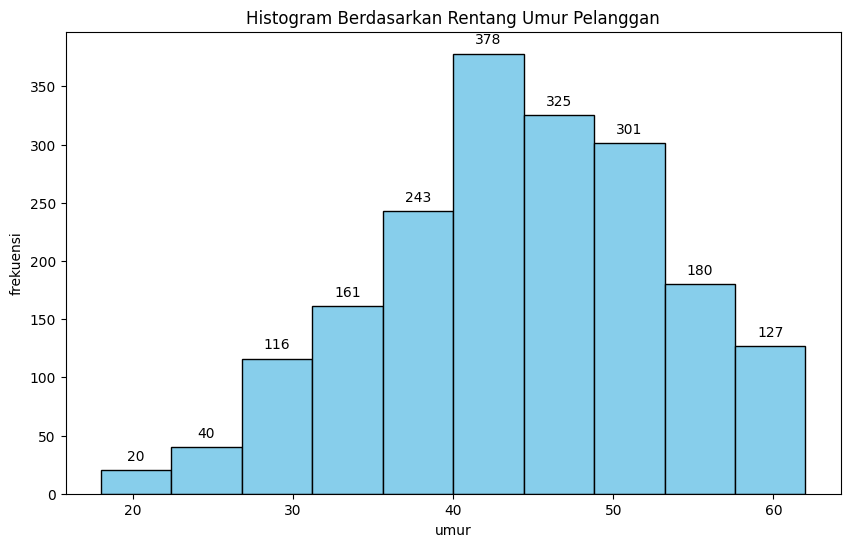

In [19]:
import matplotlib.pyplot as plt

# atur ukuran gambar
plt.figure(figsize=(10, 6))

# buat histogram rentang umur dengan anotasi nilai frekuensi
n, bins, patches = plt.hist(churn_data ['age'],
                            bins=10, 
                            color='skyblue', 
                            edgecolor='black', 
                            histtype='barstacked')

# judul plot
plt.title('Histogram Berdasarkan Rentang Umur Pelanggan')

# label sumbu x
plt.xlabel('umur')

# label sumbu y
plt.ylabel('frekuensi')

# tambahkan anotasi nilai frekuensi di atas setiap bar histogram
for i in range(len(patches)):
    plt.annotate(f'{int(n[i])}', 
                    xy=(patches[i].get_x() + patches[i].get_width() / 2, 
                     patches[i].get_height()), 
                     xytext=(0, 5), 
                     textcoords='offset points', 
                     ha='center', 
                     va='bottom')

# tampilkan plot
plt.show()


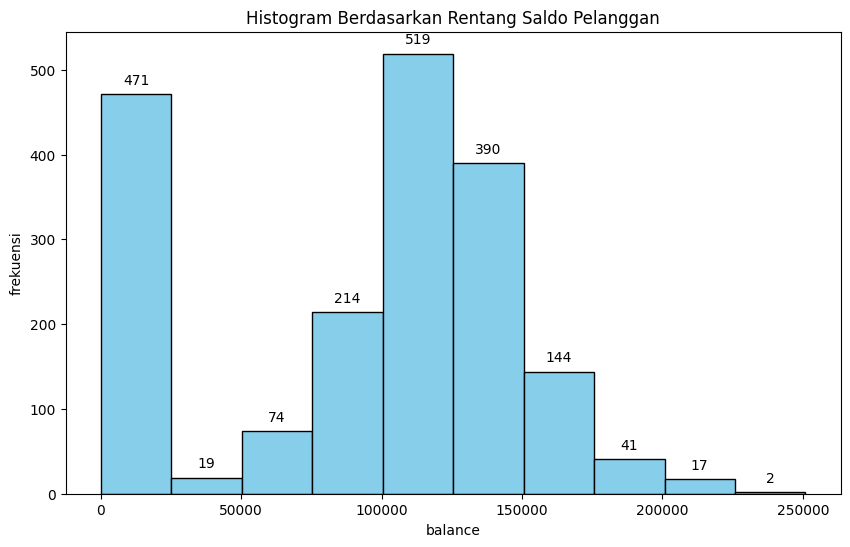

In [20]:
import matplotlib.pyplot as plt

# atur ukuran gambar
plt.figure(figsize=(10, 6))

# buat histogram rentang umur dengan anotasi nilai frekuensi
n, bins, patches = plt.hist(churn_data['balance'], 
                            bins=10, 
                            color='skyblue', 
                            edgecolor='black', 
                            histtype='barstacked')

# judul plot
plt.title('Histogram Berdasarkan Rentang Saldo Pelanggan')

# label sumbu x
plt.xlabel('balance')

# label sumbu y
plt.ylabel('frekuensi')

# tambahkan anotasi nilai frekuensi di atas setiap bar histogram
for i in range(len(patches)):
    plt.annotate(f'{int(n[i])}', 
                 xy=(patches[i].get_x() + patches[i].get_width() / 2, 
                 patches[i].get_height()), 
                 xytext=(0, 5), 
                 textcoords='offset points', 
                 ha='center', 
                 va='bottom')

# tampilkan plot
plt.show()


In [21]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1891 entries, 0 to 9998
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         1891 non-null   int64  
 1   credit_score        1891 non-null   int64  
 2   country             1891 non-null   object 
 3   gender              1891 non-null   object 
 4   age                 1891 non-null   int64  
 5   tenure              1891 non-null   int64  
 6   balance             1891 non-null   float64
 7   products_number     1891 non-null   int64  
 8   credit_card         1891 non-null   int64  
 9   active_member       1891 non-null   int64  
 10  estimated_salary    1891 non-null   float64
 11  churn               1891 non-null   int64  
 12  age_bins            1891 non-null   int64  
 13  balance_range       1891 non-null   object 
 14  balance_bins        1872 non-null   float64
 15  credit_score_range  1891 non-null   object 
dtypes: float64(

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18956\3435706097.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='tenure', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)


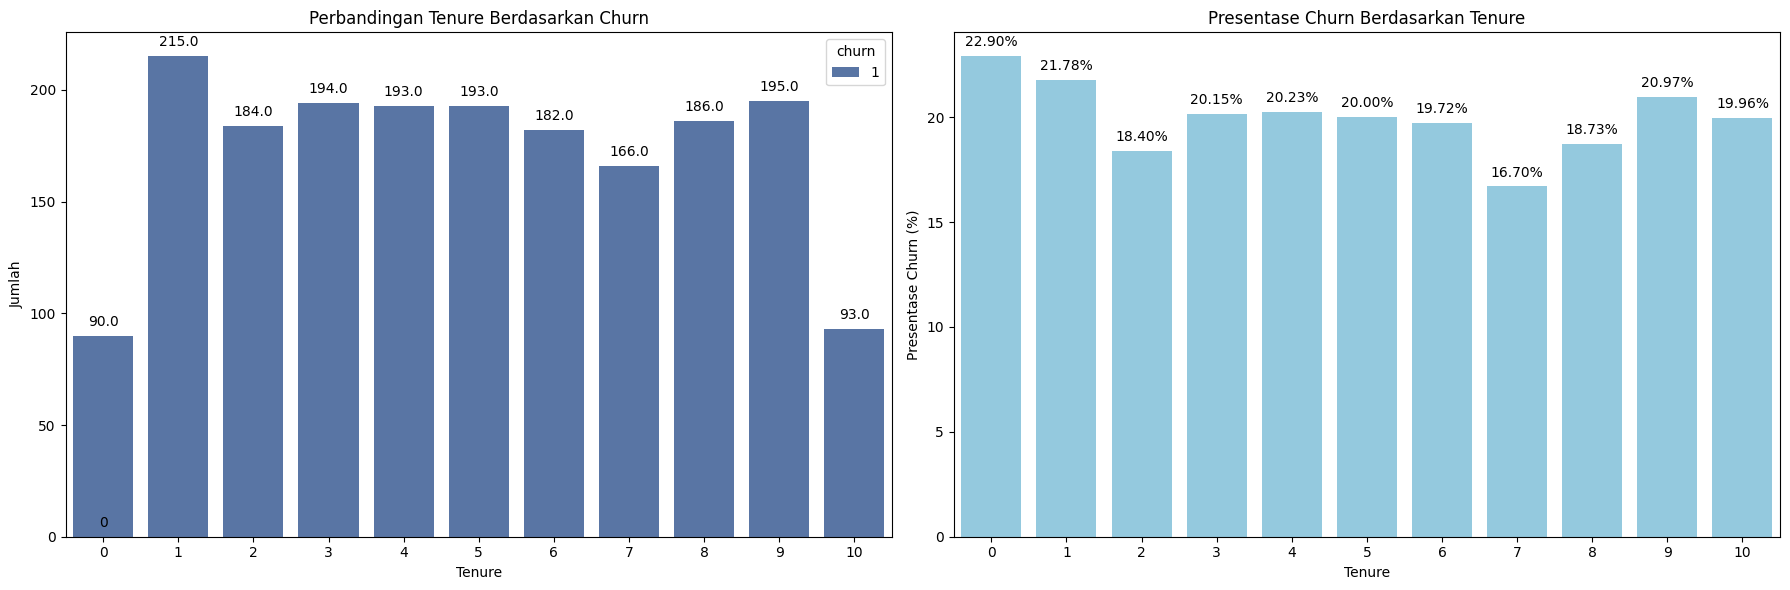

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur ukuran dan layout subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Visualisasi pertama: Countplot untuk jumlah churn berdasarkan tenure
sns.countplot(data=churn_data, x='tenure', hue='churn', palette='deep', ax=ax1)
ax1.set_title('Perbandingan Tenure Berdasarkan Churn')
ax1.set_xlabel('Tenure')
ax1.set_ylabel('Jumlah')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Visualisasi kedua: Barplot untuk presentase churn berdasarkan tenure
sns.barplot(data=df, x='tenure', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)
ax2.set_title('Presentase Churn Berdasarkan Tenure')
ax2.set_xlabel('Tenure')
ax2.set_ylabel('Presentase Churn (%)')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menampilkan plot
plt.tight_layout()
plt.show()


Berdasarkan analisis data, terdapat variasi naik turunnya tingkat churn (berdasarkan persentase) seiring dengan kategori tenure. Namun, secara umum, terlihat bahwa tingkat churn cenderung tinggi pada tenure awal dan kemudian mengalami penurunan atau stabilisasi seiring dengan berjalannya waktu tenure.

- Pada awal tenure (tenure 0 hingga 1), tingkat churn relatif tinggi, mencapai sekitar 22-23%, menunjukkan bahwa pelanggan baru memiliki kemungkinan lebih tinggi untuk berhenti berlangganan.

- Seiring dengan meningkatnya tenure (tenure 2 hingga 4), tingkat churn mulai menurun dan cenderung stabil di sekitar 18-20%.

- Meskipun ada fluktuasi dalam tingkat churn di beberapa kategori tenure (seperti pada tenure 7), secara umum tidak terlihat tren peningkatan yang signifikan setelah melewati masa-masa awal.

Kesimpulannya, meskipun ada variasi di setiap kategori tenure, terlihat bahwa tingkat churn cenderung menurun atau stabil seiring dengan berjalannya waktu. Ini mungkin menunjukkan bahwa semakin lama pelanggan menggunakan layanan, semakin sedikit kemungkinan mereka akan berhenti berlangganan. 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18956\3645182316.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='products_number', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)


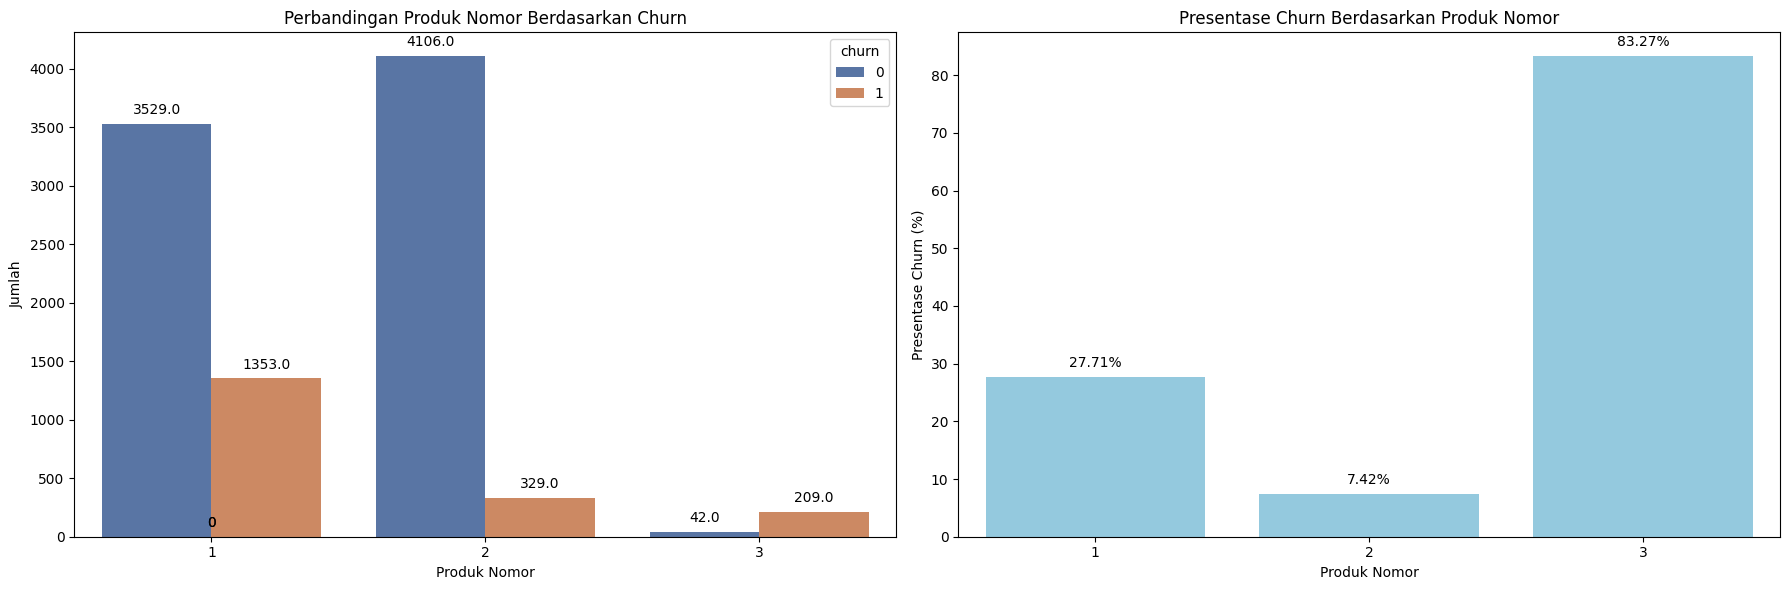

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur ukuran dan layout subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Visualisasi pertama: Countplot untuk jumlah churn berdasarkan jumlah produk
sns.countplot(data=df, x='products_number', hue='churn', palette='deep', ax=ax1)
ax1.set_title('Perbandingan Produk Nomor Berdasarkan Churn')
ax1.set_xlabel('Produk Nomor')
ax1.set_ylabel('Jumlah')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Visualisasi kedua: Barplot untuk presentase churn berdasarkan jumlah produk
sns.barplot(data=df, x='products_number', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)
ax2.set_title('Presentase Churn Berdasarkan Produk Nomor')
ax2.set_xlabel('Produk Nomor')
ax2.set_ylabel('Presentase Churn (%)')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menampilkan plot
plt.tight_layout()
plt.show()



- Jumlah pelanggan pada produk satu adalah yang tertinggi, namun persentase churnnya juga tinggi, mencapai 27,71%. Ini mungkin menunjukkan bahwa pelanggan dengan satu produk cenderung lebih rentan terhadap churn.
- Meskipun jumlah pelanggan dengan produk dua sedikit lebih rendah dari pelanggan dengan satu produk, persentase churnnya jauh lebih rendah, hanya sekitar 7.42%. Ini menunjukkan bahwa pelanggan dengan produk kedua cenderung lebih stabil.
- Sedangkan jumlah pelanggan dengan produk ketiga jauh lebih sedikit, persentase churnnya sangat tinggi, mencapai 83.27%. Ini bisa menunjukkan bahwa pelanggan dengan produk tiga mungkin mengalami kesulitan atau tidak puas dengan layanan, sehingga lebih cenderung untuk churn.

Dari analisis ini, dapat disimpulkan bahwa semakin banyak produk yang dimiliki, semakin rendah kemungkinan churnnya, dengan pengecualian pelanggan yang memiliki tiga produk, yang memiliki tingkat churn yang sangat tinggi.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18956\804183940.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='credit_card', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)


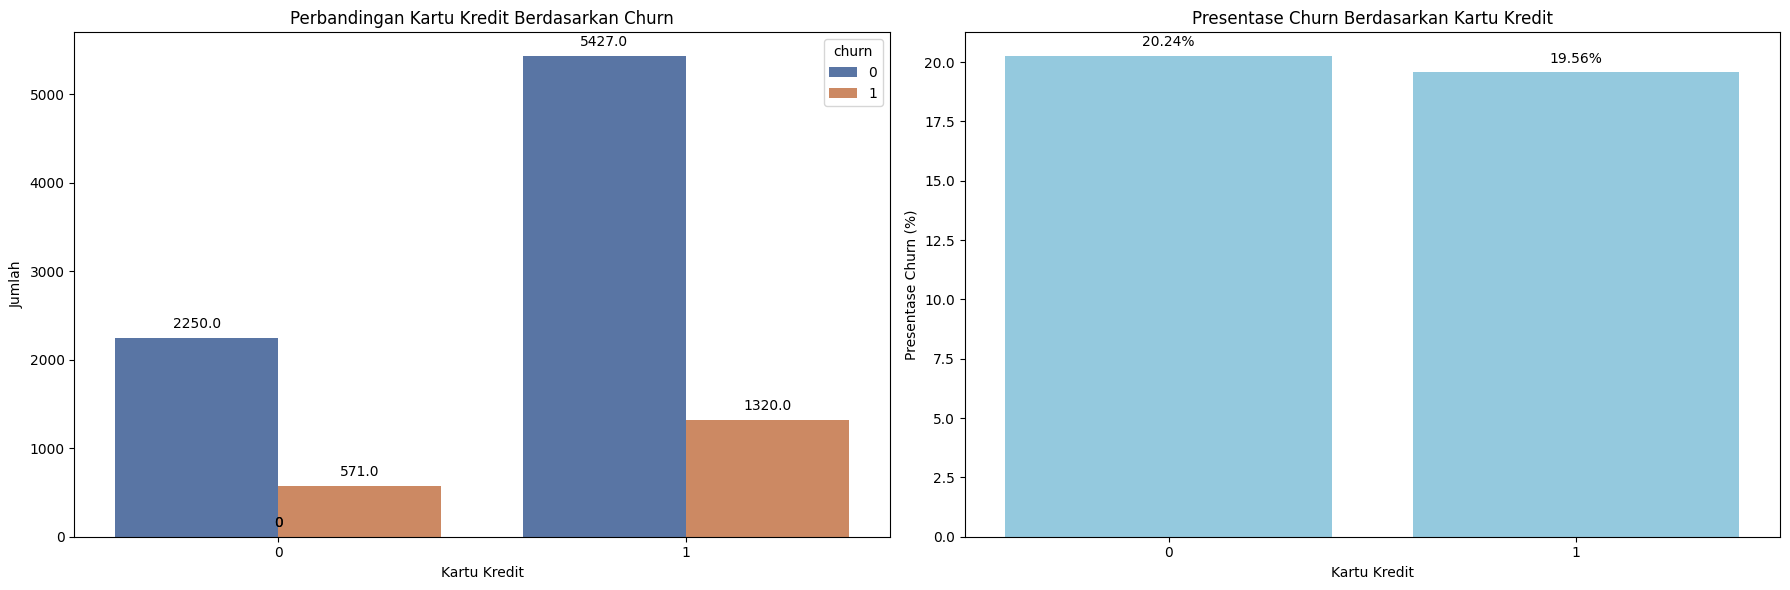

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur ukuran dan layout subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Visualisasi pertama: Countplot untuk jumlah churn berdasarkan kartu kredit
sns.countplot(data=df, x='credit_card', hue='churn', palette='deep', ax=ax1)
ax1.set_title('Perbandingan Kartu Kredit Berdasarkan Churn')
ax1.set_xlabel('Kartu Kredit')
ax1.set_ylabel('Jumlah')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Visualisasi kedua: Barplot untuk presentase churn berdasarkan kartu kredit
sns.barplot(data=df, x='credit_card', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)
ax2.set_title('Presentase Churn Berdasarkan Kartu Kredit')
ax2.set_xlabel('Kartu Kredit')
ax2.set_ylabel('Presentase Churn (%)')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menampilkan plot
plt.tight_layout()
plt.show()


- Konsumen yang tidak mempunyai Kartu kredit memiliki jumlah churn sebanyak 571 dan jumlah non-churn sebanyak 2250.
-  Konsumen yang mempunyai Kartu kredit memiliki jumlah  churn sebanyak 1320 dan jumlah non-churn sebanyak 5427.
- Presentase churn lebih tinggi untuk yang tidak memiliki kartu kredit sebesar **20.24%** dibandingkan dengan yang  memiliki kartu kredit sebesar **19.56%**

Dapat dilihat bahwa meskipun jumlah churn lebih rendah untuk yang tidak memiliki kartu kredit, presentase churnnya sedikit lebih tinggi dibandingkan dengan yang memiliki kartu kredit. 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18956\844866202.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='active_member', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)


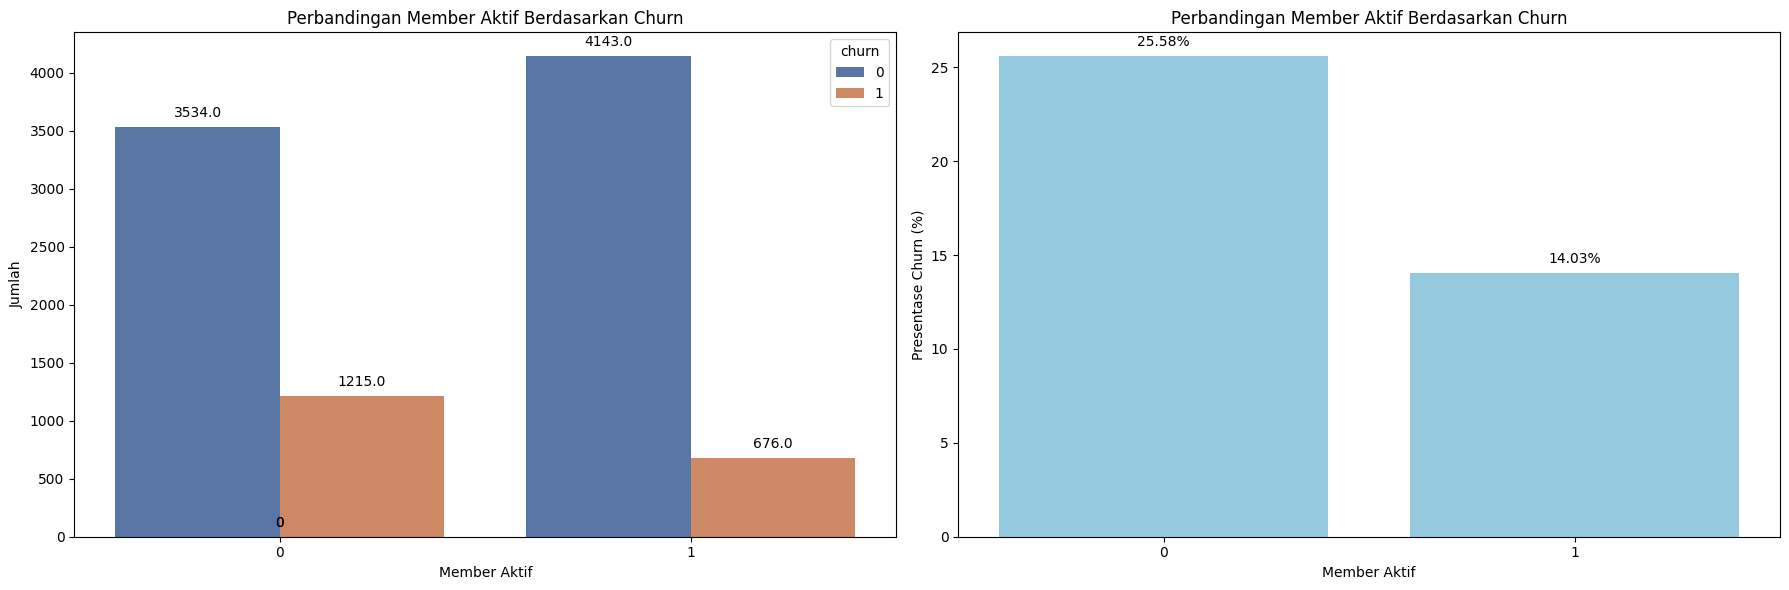

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur ukuran dan layout subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Visualisasi pertama: Countplot untuk jumlah churn berdasarkan kartu kredit
sns.countplot(data=df, x='active_member', hue='churn', palette='deep', ax=ax1)
ax1.set_title('Perbandingan Member Aktif Berdasarkan Churn')
ax1.set_xlabel('Member Aktif')
ax1.set_ylabel('Jumlah')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Visualisasi kedua: Barplot untuk presentase churn berdasarkan kartu kredit
sns.barplot(data=df, x='active_member', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)
ax2.set_title('Perbandingan Member Aktif Berdasarkan Churn')
ax2.set_xlabel('Member Aktif')
ax2.set_ylabel('Presentase Churn (%)')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menampilkan plot
plt.tight_layout()
plt.show()


Member Tidak Aktif (0) memiliki jumlah churn sebesar 25.58%, sedangkan jumlah non-churn (tidak churn) adalah 74.42%.
Member Aktif (1) memiliki jumlah churn sebesar 14.03%, sedangkan jumlah non-churn (tidak churn) adalah 85.97%.

 kita bisa melihat bahwa persentase churn lebih rendah di antara pelanggan yang merupakan anggota aktif (14,60%) dibandingkan dengan yang bukan anggota aktif (26,20%). Ini menegaskan bahwa keaktifan dalam menggunakan layanan bank memiliki dampak positif pada retensi pelanggan.

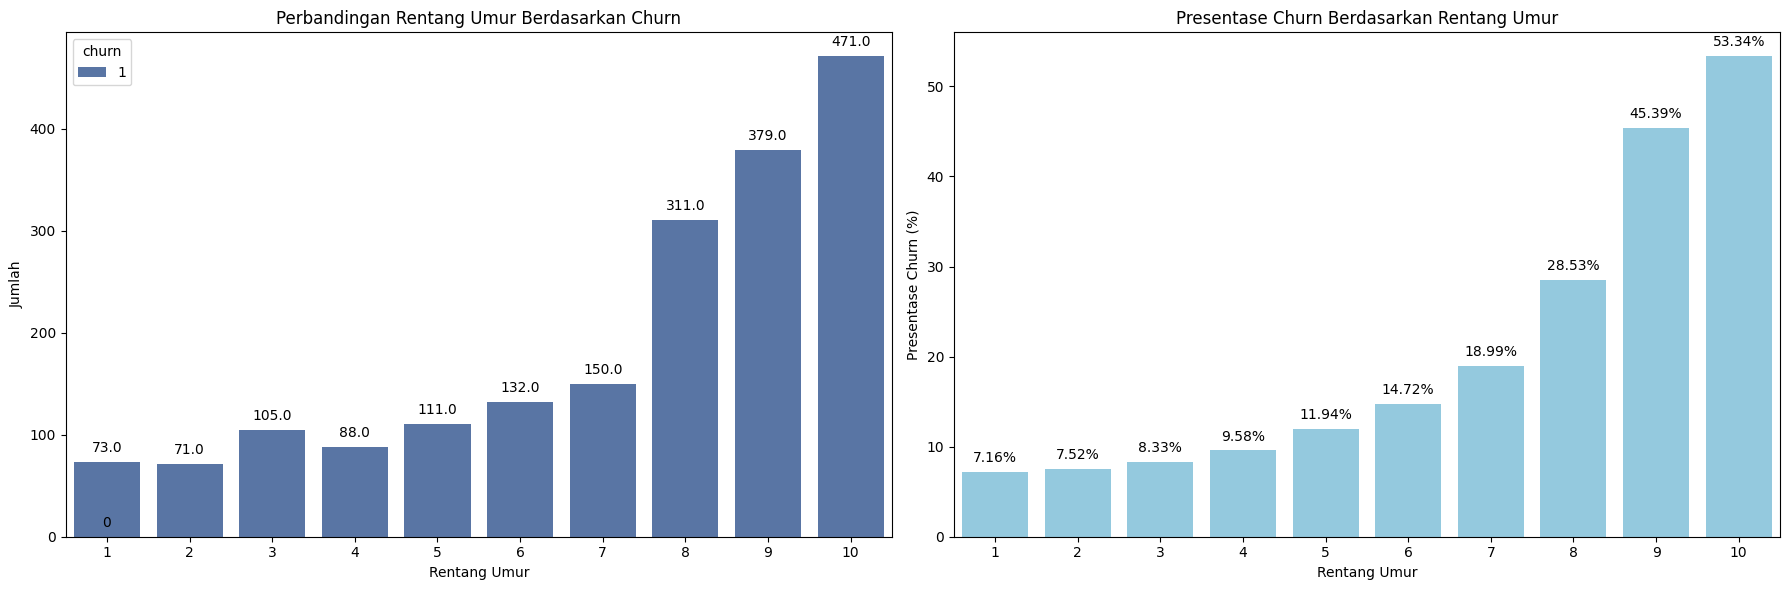

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung jumlah churn dan non-churn untuk setiap rentang umur
churn_count_by_age_bins = df.groupby('age_bins')['churn'].value_counts().unstack().fillna(0)

# Menghitung presentase churn untuk setiap rentang umur
churn_percentage_by_age_bins = churn_count_by_age_bins.div(churn_count_by_age_bins.sum(axis=1), axis=0) * 100

# Mengatur ukuran dan layout subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Visualisasi pertama: Countplot untuk jumlah churn berdasarkan rentang umur
sns.countplot(data=churn_data, x='age_bins', hue='churn', palette='deep', ax=ax1)
ax1.set_title('Perbandingan Rentang Umur Berdasarkan Churn')
ax1.set_xlabel('Rentang Umur')
ax1.set_ylabel('Jumlah')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Visualisasi kedua: Barplot untuk presentase churn berdasarkan rentang umur
sns.barplot(data=churn_percentage_by_age_bins.reset_index(), x='age_bins', y=1, color='skyblue', ax=ax2)
ax2.set_title('Presentase Churn Berdasarkan Rentang Umur')
ax2.set_xlabel('Rentang Umur')
ax2.set_ylabel('Presentase Churn (%)')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menampilkan plot
plt.tight_layout()
plt.show()



- Terdapat kecenderungan bahwa semakin tua rentang umur, semakin tinggi presentase churn. Rentang umur dengan presentase churn tertinggi terletak pada kategori umur yang lebih tua, yaitu pada kategori umur 9 dan 10.
- Rentang umur dengan presentase churn terendah terletak pada kategori umur yang lebih muda, khususnya pada kategori umur 1 dan 2.

Rentang umur yang lebih muda cenderung memiliki presentase churn yang lebih rendah, mungkin karena kecenderungan untuk memiliki koneksi jangka panjang dengan penyedia layanan.
Rentang umur yang lebih tua cenderung memiliki presentase churn yang lebih tinggi, mungkin karena perubahan kebutuhan atau preferensi pelanggan seiring bertambahnya usia.

Perlu adanya strategi pemasaran yang berbeda untuk masing-masing rentang umur. Misalnya, fokus pada mempertahankan pelanggan di rentang umur yang lebih tua dengan menawarkan layanan yang disesuaikan dengan kebutuhan mereka.

cek age dengan balance, apa jelek baru churn, tanggungan.

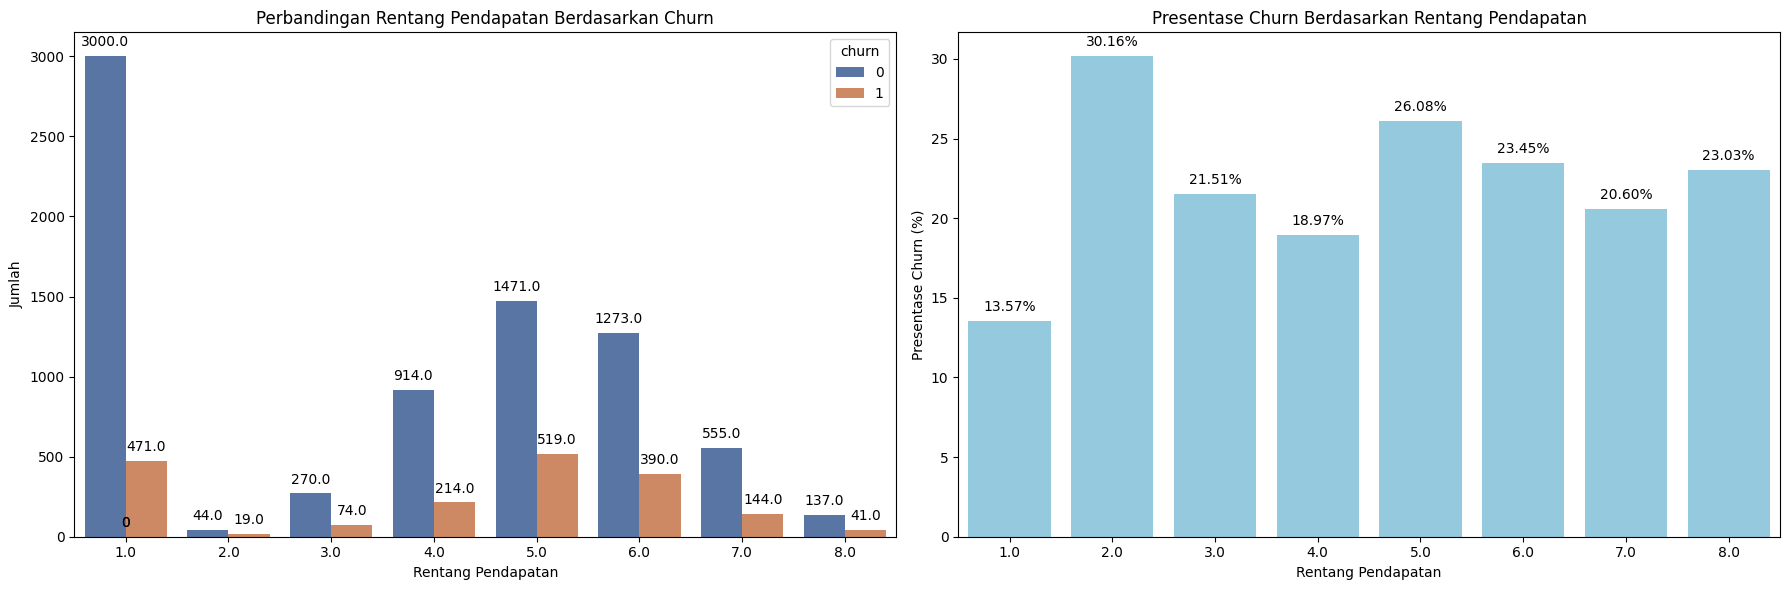

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung jumlah churn dan non-churn untuk setiap rentang pendapatan
churn_count_by_balance_bins = df.groupby('balance_bins')['churn'].value_counts().unstack().fillna(0)

# Menghitung presentase churn untuk setiap rentang pendapatan
churn_percentage_by_balance_bins = churn_count_by_balance_bins.div(churn_count_by_balance_bins.sum(axis=1), axis=0) * 100

# Mengatur ukuran dan layout subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Visualisasi pertama: Countplot untuk jumlah churn berdasarkan rentang pendapatan
sns.countplot(data=df, x='balance_bins', hue='churn', palette='deep', ax=ax1)
ax1.set_title('Perbandingan Rentang Pendapatan Berdasarkan Churn')
ax1.set_xlabel('Rentang Pendapatan')
ax1.set_ylabel('Jumlah')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Visualisasi kedua: Barplot untuk presentase churn berdasarkan rentang pendapatan
sns.barplot(data=churn_percentage_by_balance_bins.reset_index(), x='balance_bins', y=1, color='skyblue', ax=ax2)
ax2.set_title('Presentase Churn Berdasarkan Rentang Pendapatan')
ax2.set_xlabel('Rentang Pendapatan')
ax2.set_ylabel('Presentase Churn (%)')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menampilkan plot
plt.tight_layout()
plt.show()


Terdapat kecenderungan bahwa semakin tinggi rentang pendapatan, semakin rendah presentase churn.
Rentang pendapatan dengan presentase churn tertinggi terletak pada kategori pendapatan yang lebih rendah, yaitu pada kategori pendapatan 2.0.
Rentang pendapatan dengan presentase churn terendah terletak pada kategori pendapatan yang lebih tinggi, khususnya pada kategori pendapatan 1.0.
- Pelanggan dengan pendapatan yang lebih rendah cenderung memiliki presentase churn yang lebih tinggi. Hal ini mungkin disebabkan oleh keterbatasan keuangan yang membuat mereka lebih sensitif terhadap perubahan harga atau kualitas layanan.
- Pelanggan dengan pendapatan yang lebih tinggi cenderung memiliki presentase churn yang lebih rendah. Mereka mungkin lebih mampu membayar layanan tambahan atau lebih puas dengan layanan yang mereka terima.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18956\3802344763.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='gender', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)


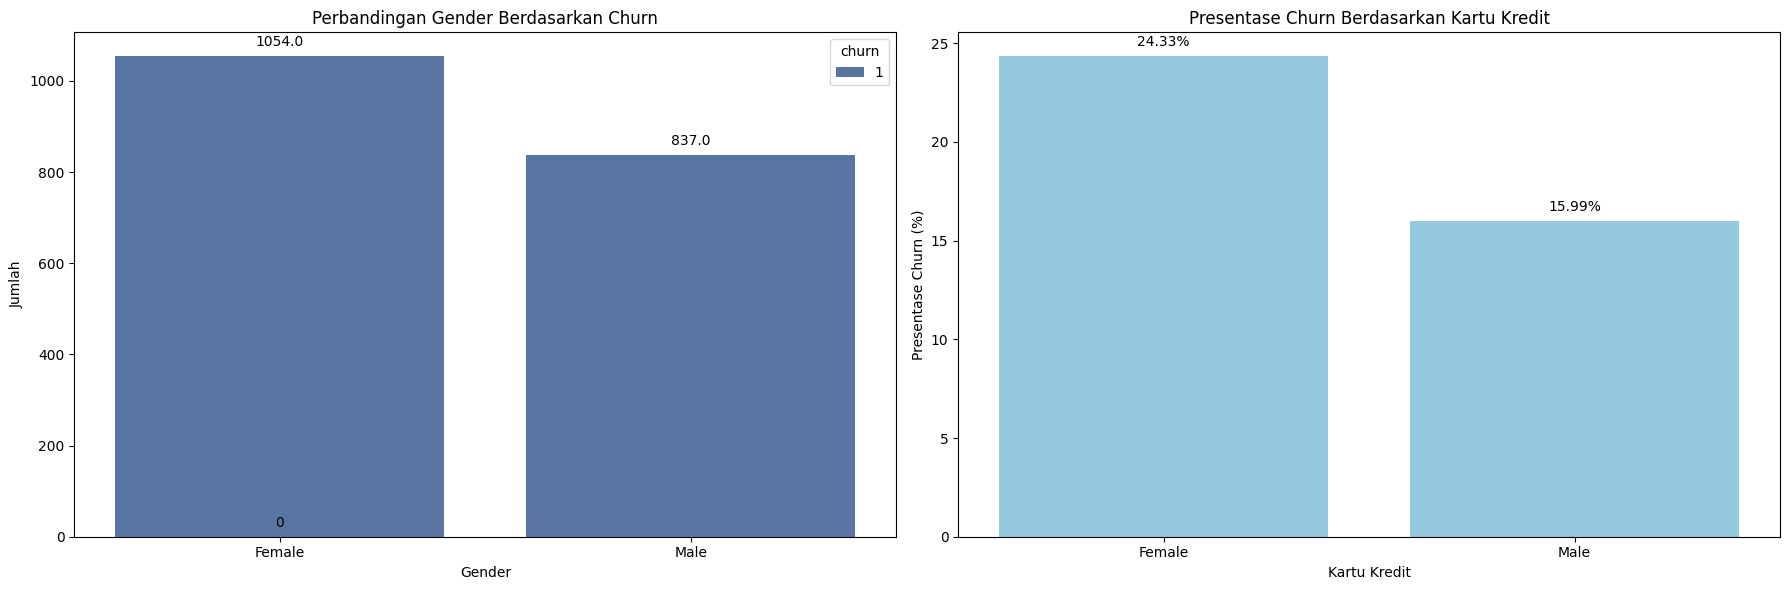

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur ukuran dan layout subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Visualisasi pertama: Countplot untuk jumlah churn berdasarkan kartu kredit
sns.countplot(data=churn_data, x='gender', hue='churn', palette='deep', ax=ax1)
ax1.set_title('Perbandingan Gender Berdasarkan Churn')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Jumlah')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Visualisasi kedua: Barplot untuk presentase churn berdasarkan kartu kredit
sns.barplot(data=df, x='gender', y='churn', ci=None, estimator=lambda x: sum(x == 1) / len(x) * 100, color='skyblue', ax=ax2)
ax2.set_title('Presentase Churn Berdasarkan Kartu Kredit')
ax2.set_xlabel('Kartu Kredit')
ax2.set_ylabel('Presentase Churn (%)')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menampilkan plot
plt.tight_layout()
plt.show()

## **2. Melihat tingkat hubungan faktor lain terhadap tingkat churn**

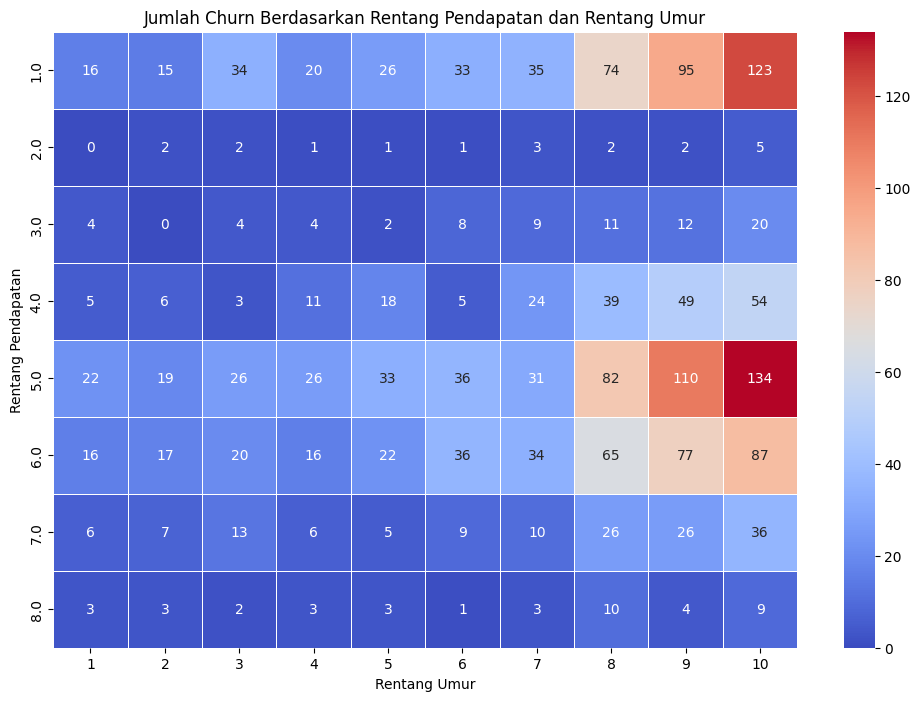

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung jumlah churn dan non-churn untuk setiap rentang pendapatan dan rentang usia
age_bins_count_by_balance_bins = churn_data.groupby('balance_bins')['age_bins'].value_counts().unstack().fillna(0).astype(int)

# Menampilkan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(age_bins_count_by_balance_bins, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Jumlah Churn Berdasarkan Rentang Pendapatan dan Rentang Umur')
plt.xlabel('Rentang Umur')
plt.ylabel('Rentang Pendapatan')
plt.show()


- Rentang pendapatan 1, 5, dan 6 memiliki jumlah churn yang lebih tinggi dibandingkan dengan rentang pendapatan lainnya. Ini menunjukkan bahwa pelanggan dengan pendapatan dalam rentang tersebut cenderung lebih rentan untuk melakukan churn.

- Di sisi lain, rentang usia 8, 9, dan 10 memiliki kecenderungan churn yang lebih tinggi dari rentang usia lainnya. Hal ini menunjukkan bahwa pelanggan pada rentang usia tersebut lebih mungkin untuk melakukan churn.

- pola umum menunjukkan bahwa rentang usia yang lebih tinggi cenderung memiliki persentase churn yang lebih besar, terutama pada rentang pendapatan yang lebih tinggi. Pola ini menunjukkan bahwa faktor-faktor yang berbeda, seperti pendapatan dan usia, berkontribusi terhadap tingginya tingkat churn. 


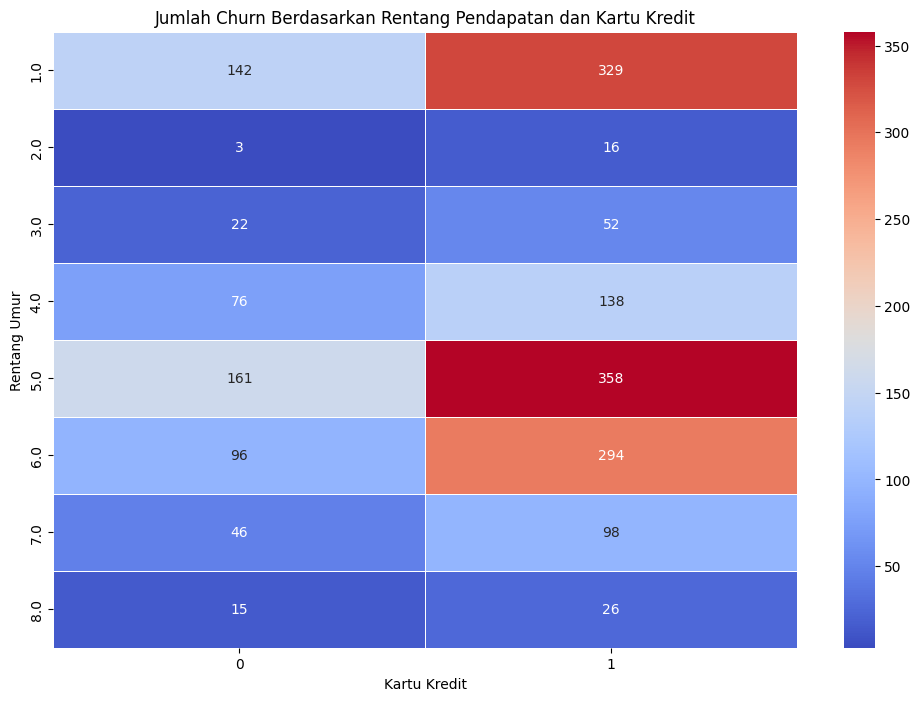

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung jumlah churn dan non-churn untuk setiap rentang pendapatan dan rentang usia
age_bins_count_by_credit_card = churn_data.groupby('balance_bins')['credit_card'].value_counts().unstack().fillna(0).astype(int)

# Menampilkan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(age_bins_count_by_credit_card, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Jumlah Churn Berdasarkan Rentang Pendapatan dan Kartu Kredit')
plt.xlabel('Kartu Kredit')
plt.ylabel('Rentang Umur')
plt.show()

- Pada rentang umur 1, 5, dan 6 memiliki jumlah churn paling tinggi. 
- Secara umum terdapat pola bahwa semakin tinggi rentang umur semakin tinggi pula jumlah churn terutama untuk konsumen yang menggunakan kartu kredit

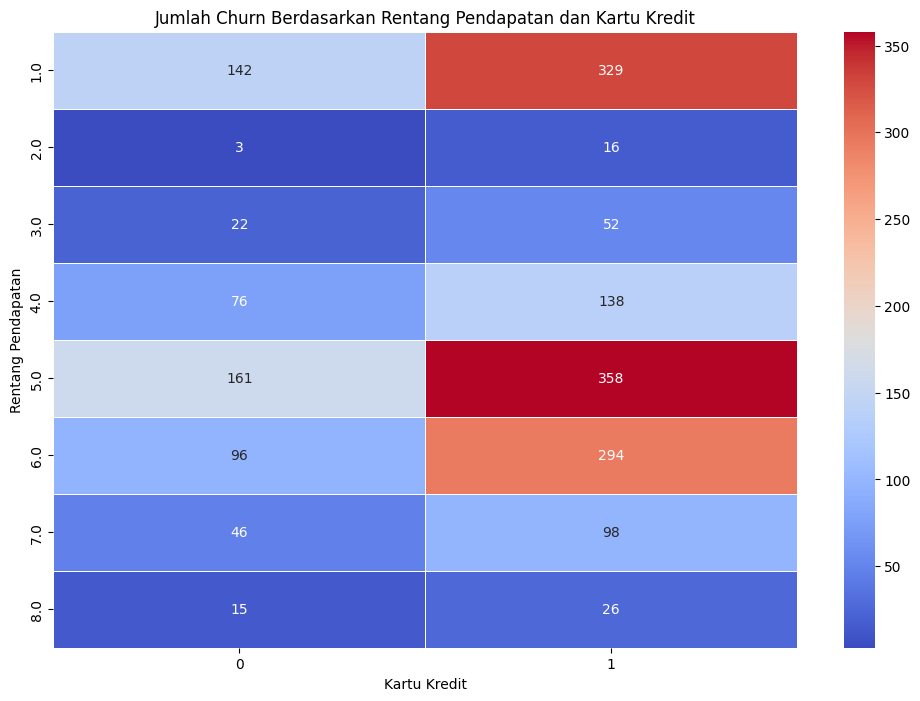

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung jumlah churn dan non-churn untuk setiap rentang pendapatan dan kartu kredit
credit_card_count_by_balance_bins = churn_data.groupby('balance_bins')['credit_card'].value_counts().unstack().fillna(0).astype(int)

# Menampilkan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(credit_card_count_by_balance_bins, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Jumlah Churn Berdasarkan Rentang Pendapatan dan Kartu Kredit')
plt.xlabel('Kartu Kredit')
plt.ylabel('Rentang Pendapatan')
plt.show()


- Konsumen yang mempunyai kartu kredit cenderung memiliki jumlah churn yang lebih tinggi daripada yang tidak memiliki kartu kredit.
- Dengan demikian, terdapat kecenderungan bahwa rentang pendapatan yang lebih tinggi dan memiliki kartu kredit cenderung memiliki jumlah churn yang lebih tinggi.

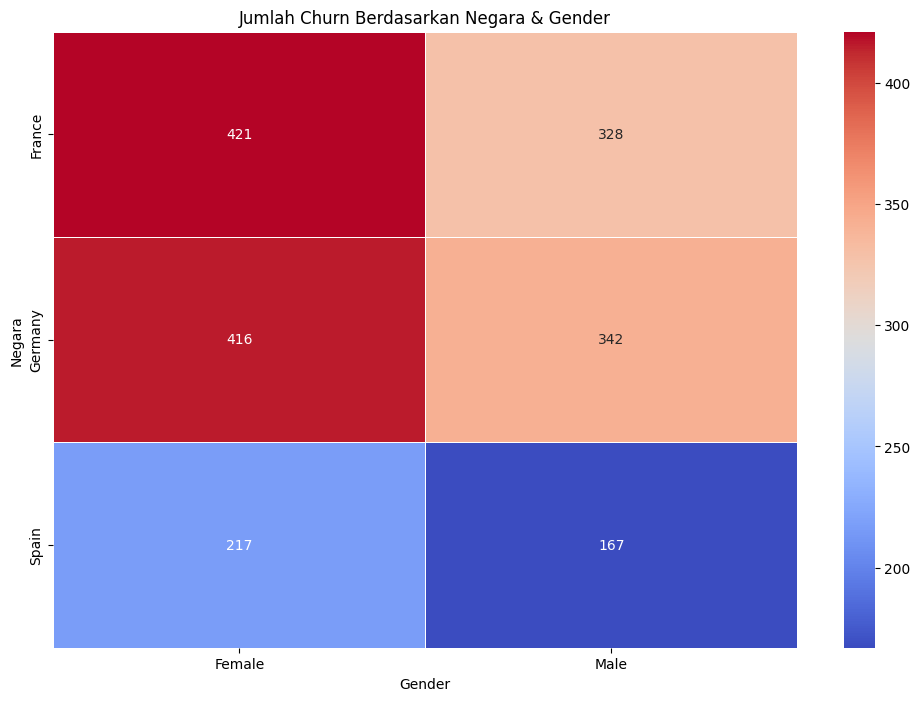

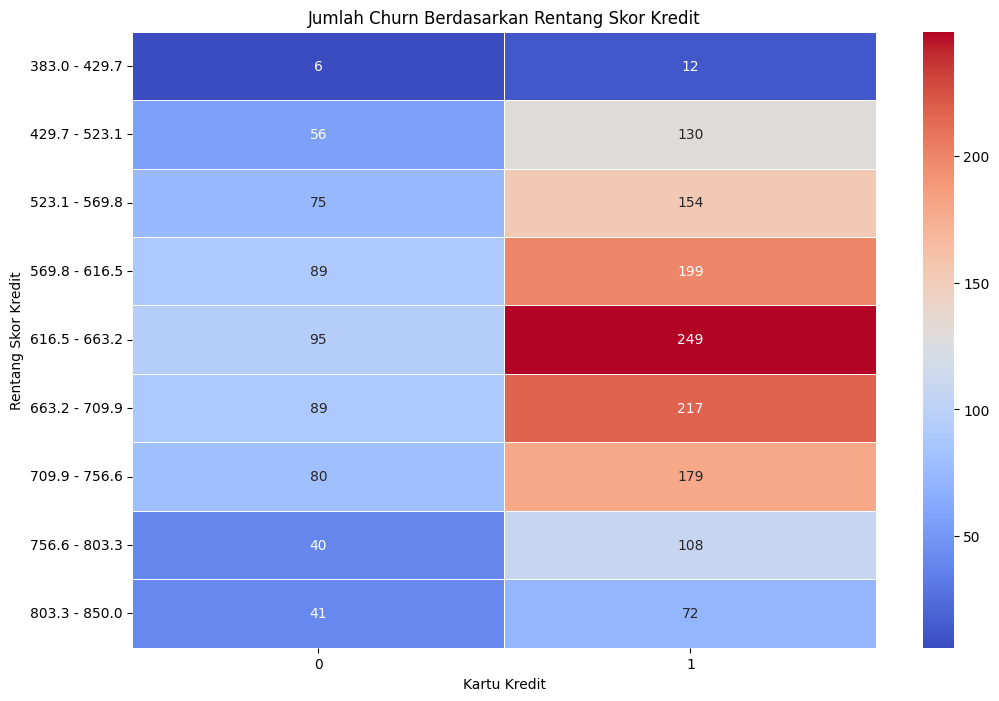

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung jumlah churn dan non-churn untuk setiap rentang pendapatan dan rentang usia
country_by_gender = churn_data.groupby('country')['gender'].value_counts().unstack().fillna(0).astype(int)

# Menampilkan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(country_by_gender, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Jumlah Churn Berdasarkan Negara & Gender')
plt.xlabel('Gender')
plt.ylabel('Negara')
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung jumlah churn dan non-churn untuk setiap rentang pendapatan dan rentang usia
credit_card_by_credit_score = churn_data.groupby('credit_score_range')['credit_card'].value_counts().unstack().fillna(0).astype(int)

# Menampilkan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(credit_card_by_credit_score , annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Jumlah Churn Berdasarkan Rentang Skor Kredit')
plt.xlabel('Kartu Kredit')
plt.ylabel('Rentang Skor Kredit')
plt.show()



ngebatasin kredit diatas 200 itu udah chunr

Berdasarkan visualisasi di atas menunjukkan bahwa di setiap negara gender perempuan cenderung melakukan churn dibandingkan gender laki-laki.
Sedangkan pada visualisasi kedua menggambarkan bahwa terdapat peningkatan jumlah churn dari rentang skor kredit 569.8 - 616.5 ke 616.5 - 663.2, namun kemudian mengalami penurunan di rentang skor kredit berikutnya. Jumlah churn cenderung meningkat seiring dengan peningkatan rentang skor kredit terutama pada pemilik kartu kredit. Kemudian, rentang skor kredit yang lebih tinggi cenderung memiliki jumlah churn yang lebih rendah.

**Pengaruh Rentang Pendapatan:**
Rentang pendapatan 1, 5, dan 6 menunjukkan jumlah churn yang lebih tinggi.
Hal ini menandakan bahwa pelanggan dengan pendapatan di rentang tersebut cenderung lebih rentan untuk melakukan churn.

**Pengaruh Rentang Usia:**
Rentang usia 8, 9, dan 10 memiliki kecenderungan churn yang lebih tinggi.
Ini menunjukkan bahwa pelanggan pada rentang usia tersebut lebih mungkin untuk melakukan churn.

**Polap Perilaku Umum:**
Pola umum menunjukkan bahwa rentang usia yang lebih tinggi cenderung memiliki persentase churn yang lebih tinggi, terutama pada rentang pendapatan yang lebih tinggi.
Rentang umur 1, 5, dan 6 memiliki jumlah churn paling tinggi, menunjukkan kecenderungan bahwa semakin tinggi rentang usia, semakin tinggi pula jumlah churn, terutama untuk konsumen yang menggunakan kartu kredit.

**Pengaruh Kartu Kredit:**
Konsumen yang memiliki kartu kredit cenderung memiliki jumlah churn yang lebih tinggi daripada yang tidak memiliki kartu kredit.
Terdapat kecenderungan bahwa rentang pendapatan yang lebih tinggi dan memiliki kartu kredit cenderung memiliki jumlah churn yang lebih tinggi.

# ```ANALYSIS DATA```

## Odd, Hipotesis, Ordinary Least Squares (OLS), Signifikansi: R-Square

In [33]:
# Menghitung jumlah churn dan non-churn untuk setiap nilai 'age'
churn_count_by_age = df.groupby('age')['churn'].value_counts().unstack().fillna(0)

# Menghitung proporsi churn untuk setiap nilai 'age'
churn_percentage_by_age = churn_count_by_age.div(churn_count_by_age.sum(axis=1), axis=0)

# Menghitung odd ratio untuk 'age'
odd_ratio_age = churn_percentage_by_age[1] / churn_percentage_by_age[0]

# Urutkan secara descending
odd_ratio_age_sorted = odd_ratio_age.sort_values(ascending=False)

# Menghitung jumlah churn dan non-churn untuk setiap nilai 'balance'
churn_count_by_balance = df.groupby('balance')['churn'].value_counts().unstack().fillna(0)

# Menghitung proporsi churn untuk setiap nilai 'balance'
churn_percentage_by_balance = churn_count_by_balance.div(churn_count_by_balance.sum(axis=1), axis=0)

# Menghitung odd ratio untuk 'balance'
odd_ratio_balance = churn_percentage_by_balance[1] / churn_percentage_by_balance[0]

# Menghitung odd ratio untuk 'active_member'
odd_ratio_active_member = df.groupby('active_member')['churn'].value_counts().unstack().fillna(0).iloc[1] / df.groupby('active_member')['churn'].value_counts().unstack().fillna(0).iloc[0]

# Menghitung odd ratio untuk 'credit_card'
odd_ratio_credit_card = df.groupby('credit_card')['churn'].value_counts().unstack().fillna(0).iloc[1] / df.groupby('credit_card')['churn'].value_counts().unstack().fillna(0).iloc[0]

# Menampilkan odd ratio untuk semua variabel
print("Odd Ratio for Age:")
print(odd_ratio_age_sorted)
print()


Odd Ratio for Age:
age
56    2.500000
52    1.631579
54    1.515152
55    1.323529
51    1.188679
53    1.147059
50    1.031746
49    1.000000
60    0.966667
57    0.945946
59    0.937500
48    0.897727
47    0.765306
58    0.710526
62    0.677419
46    0.651852
61    0.625000
45    0.584507
43    0.401914
44    0.380435
42    0.303279
40    0.247813
41    0.218855
39    0.199430
22    0.166667
38    0.149758
37    0.141827
35    0.134293
36    0.129032
24    0.118644
33    0.110553
18    0.100000
28    0.088000
31    0.086253
29    0.084375
34    0.077295
26    0.075269
32    0.075130
30    0.072607
27    0.066327
23    0.064516
21    0.060000
20    0.052632
25    0.040541
19    0.038462
dtype: float64



Untuk rentang usia yang lebih muda (misalnya, 18 hingga 25 tahun), odd ratio cenderung rendah, yang menunjukkan bahwa konsumen dalam rentang usia ini memiliki kecenderungan yang lebih rendah untuk churn.
Namun, odd ratio mulai meningkat secara signifikan saat usia konsumen mencapai sekitar 30 tahun dan seterusnya. Analisis ini menunjukkan bahwa usia konsumen memiliki pengaruh yang signifikan terhadap tingkat churn, dengan kecenderungan churn yang lebih tinggi terlihat pada konsumen yang lebih tua.

In [34]:
print("Odd Ratio for Balance:")
print(odd_ratio_balance)
print()

Odd Ratio for Balance:
balance
0.00         0.155771
3768.69           inf
12459.19          inf
14262.80     0.000000
16893.59     0.000000
               ...   
216109.88         inf
221532.80    0.000000
222267.63         inf
238387.56         inf
250898.09         inf
Length: 6102, dtype: float64



odd rasio sebesar 0,15 atau 15%. Terdapat nilai odd ratio yang sangat tinggi (infiniti) untuk beberapa rentang balance yang berarti rentang balance sangat tinggi cenderung tidak churn. Sebaliknya, terdapat juga nilai odd ratio yang sangat rendah memiliki kecenderungan tinggi untuk churn. Analisis ini menunjukkan bahwa saldo akun konsumen adalah faktor penting yang memengaruhi tingkat churn, dengan kecenderungan untuk churn cenderung lebih rendah pada konsumen dengan saldo yang lebih tinggi, dan sebaliknya. 

In [35]:
print("Odd Ratio for Active Member:")
print(odd_ratio_active_member)
print()


Odd Ratio for Active Member:
churn
0    1.172326
1    0.556379
dtype: float64



Polanya menunjukkan bahwa menjadi anggota yang aktif cenderung memiliki pengaruh yang signifikan dalam mengurangi kemungkinan churn. Konsumen yang aktif memiliki Odd Ratio yang lebih rendah, menunjukkan bahwa mereka memiliki kecenderungan yang lebih rendah untuk melakukan churn dibandingkan dengan konsumen yang tidak aktif. 

In [36]:

print("Odd Ratio for Credit Card:")
print(odd_ratio_credit_card)
print()


Odd Ratio for Credit Card:
churn
0    2.412000
1    2.311734
dtype: float64



Untuk pelanggan yang memegang kartu kredit (1), Odd Ratio adalah sekitar 2.31.
Sedangkan untuk pelanggan yang tidak memegang kartu kredit (0), Odd Ratio adalah sekitar 2.41.
Hal ini menunjukkan bahwa ada sedikit kecenderungan bahwa pemegang kartu kredit memiliki peluang churn yang lebih rendah daripada yang tidak memegang kartu kredit, namun perbedaannya tidak signifikan. Dengan kata lain, memiliki atau tidak memiliki kartu kredit tidak terlalu memengaruhi peluang seorang pelanggan untuk churn.

## `Hipotesis Analisis`

**Hipotesis 1: Usia Mempengaruhi Tingkat Churn**

Hipotesis: Terdapat hubungan positif antara usia pelanggan dengan tingkat churn, semakin tua usia pelanggan semakin tinggi kemungkinan mereka untuk churn.

Rationale: Pelanggan yang lebih tua mungkin memiliki kebutuhan atau preferensi yang berubah dari waktu ke waktu, membuat mereka lebih cenderung untuk mencari alternatif layanan.

**Hipotesis 2: Saldo Akun Mempengaruhi Tingkat Churn**

Hipotesis: Terdapat hubungan negatif antara saldo akun pelanggan dengan tingkat churn. Semakin tinggi saldo akun pelanggan semakin rendah kemungkinan mereka untuk churn.

Rationale: Pelanggan dengan saldo akun yang lebih tinggi mungkin merasa lebih terikat secara finansial atau emosional dengan bank, mengurangi kemungkinan mereka untuk mencari layanan dari penyedia lain.

**Hipotesis 3: Keterlibatan Aktif Mempengaruhi Tingkat Churn**

Hipotesis: Terdapat hubungan negatif antara keterlibatan aktif pelanggan dengan tingkat churn. Pelanggan yang aktif memiliki tingkat churn yang lebih rendah daripada yang tidak aktif.

Rationale: Pelanggan yang aktif mungkin merasa lebih terhubung dengan bank dan merasakan manfaat yang lebih besar dari layanan yang disediakan, mengurangi keinginan mereka untuk mencari alternatif lain. 

 ## ``` Melihat hubungan variabel dari corelasi```

**metode korelasi**

- pearson : hubungan linier antar variabel, distribusi normal, data interval.
- kendal : mengukur kesaman dalam urutan peringakt, tanpa asumsi distribusi, data ordinal.
- spearman : mengukur kesamaan dalam peringkat variabel, anpa asumsi distribusi, data ordinal/interval.

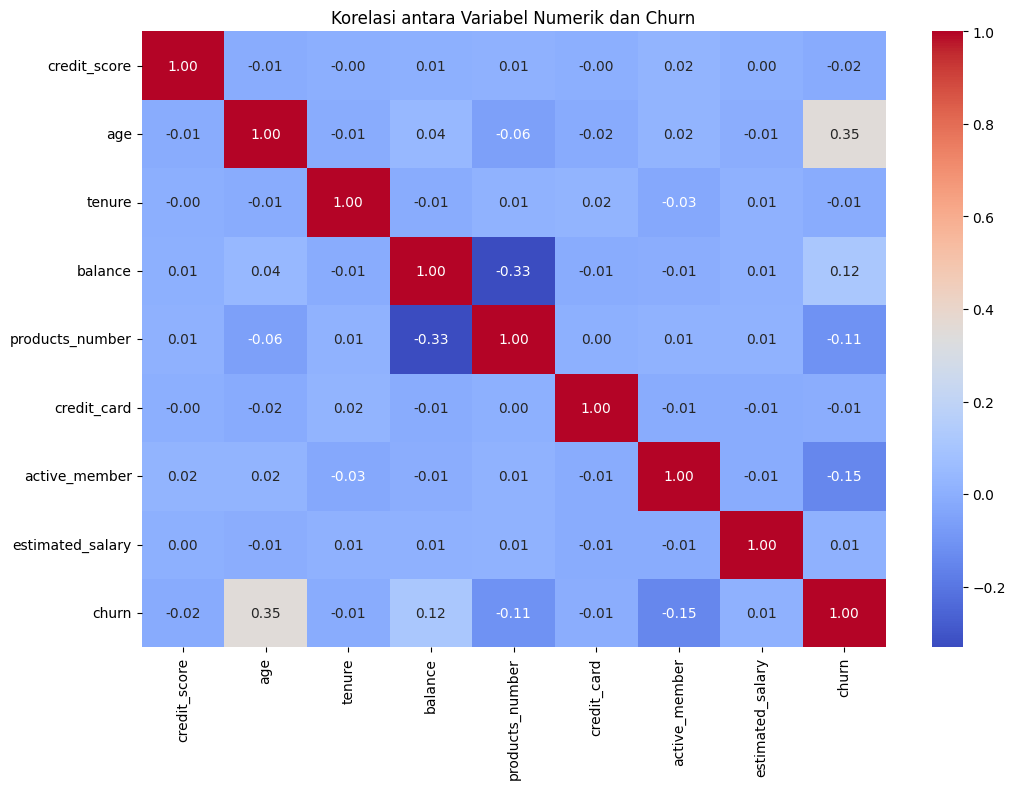

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Memilih kolom numerik yang relevan
numeric_columns = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']

# Menghitung korelasi antar kolom numerik
correlation_matrix = df[numeric_columns + ['churn']].corr()

# Membuat gambar (figure) baru dengan ukuran 12x8 inch
plt.figure(figsize=(12, 8))

# Membuat heatmap untuk visualisasi korelasi
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})

# Menampilkan judul plot
plt.title('Korelasi antara Variabel Numerik dan Churn')

# Menampilkan plot
plt.show()


Melihat korelasi positif antara variabe churn dengan age dan balance yakni sebesar 0,35 dan 0,12 yang artinya masuk dalam kategori korelasi lemah. Meskipun begitu dapat ditetapkan bahwa terdapat antara churn dengan age dan balance. sehingga dapat diartikan bahwa semakin tua usia pelanggan maka semakin tinggi peluang untuk mereka churn. Sedangkan aktif member memiliki korelasi negatif terhadap churn sebesar 0,15 sehingga dapat diartikan bahwa member tidak aktif cenderung memiliki churn tinggi dibandingkan member aktif.

 ## ``` Uji Hipotesis```

**Hipotesis 1 (H1)**: Terdapat hubungan positif antara usia pelanggan dengan tingkat churn, di mana semakin tua usia pelanggan, semakin tinggi kemungkinan mereka untuk churn.

**Hipotesis Alternatif (H1)**: Usia pelanggan berpengaruh signifikan terhadap tingkat churn.

**Hipotesis Nol (H0)**: Tidak ada hubungan antara usia pelanggan dengan tingkat churn, atau tidak ada perbedaan yang signifikan dalam tingkat churn berdasarkan usia pelanggan.


**Hipotesis 2 (H2)**: Terdapat hubungan positif antara saldo akun pelanggan dengan tingkat churn, di mana semakin tinggi saldo akun pelanggan, semakin rendah kemungkinan mereka untuk churn.

**Hipotesis Alternatif (H2)**: Saldo akun pelanggan berpengaruh signifikan terhadap tingkat churn.

**Hipotesis Nol (H0)**: Tidak ada hubungan antara saldo akun pelanggan dengan tingkat churn, atau tidak ada perbedaan yang signifikan dalam tingkat churn berdasarkan saldo akun pelanggan.



**Hipotesis 3 (H3)**: Terdapat hubungan negatif antara keterlibatan aktif pelanggan dengan tingkat churn, di mana pelanggan yang aktif memiliki tingkat churn yang lebih rendah daripada yang tidak aktif.

**Hipotesis Alternatif (H3)**: Keterlibatan aktif pelanggan berpengaruh signifikan terhadap tingkat churn.

**Hipotesis Nol (H0)**: Tidak ada hubungan antara keterlibatan aktif pelanggan dengan tingkat churn, atau tidak ada perbedaan yang signifikan dalam tingkat churn berdasarkan keterlibatan aktif pelanggan.

# ```OLS```

In [38]:
import statsmodels.api as sm

# Menentukan variabel dependen (tingkat churn)
y = df['churn']

# Menentukan variabel independen (age dan balance)
X = df[['age', 'balance', 'active_member']]

# Menambahkan kolom konstan untuk model regresi
X = sm.add_constant(X)

# Membuat model regresi linier menggunakan OLS
ols_model = sm.OLS(y, X)

# Melakukan fitting model ke data
result = ols_model.fit()

# Menampilkan hasil summary
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     598.5
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:06:06   Log-Likelihood:                -3943.6
No. Observations:                9568   AIC:                             7895.
Df Residuals:                    9564   BIC:                             7924.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.3936      0.017    -22.749

Koefisien (coef): Koefisien menunjukkan seberapa besar perubahan dalam variabel dependen (churn) yang diharapkan ketika variabel independen (age, balance, dan active_member) mengalami peningkatan satu satuan. Misalnya, koefisien untuk age adalah 0.0160, yang berarti bahwa ketika usia pelanggan naik satu tahun, kita harapkan peningkatan 0.0160 pada nilai churn.

P-value: P-value adalah ukuran signifikansi statistik dari model regresi secara keseluruhan. P-value yang sangat kecil (0.00) menunjukkan bahwa setidaknya satu variabel independen memiliki pengaruh signifikan terhadap variabel dependen.

R-squared: R-squared adalah proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh variabel independen dalam model. Nilai R-squared sebesar 0.158 menunjukkan bahwa sekitar 15.8% variasi dalam tingkat churn dapat dijelaskan oleh variabel independen dalam model ini.

Kesimpulan: Berdasarkan hasil OLS ini, variabel independen (age, balance, dan active_member) secara bersama-sama memiliki pengaruh yang signifikan terhadap tingkat churn, dengan p-value yang sangat rendah. Oleh karena itu, hasil ini mendukung hipotesis bahwa ketiga variabel tersebut mempengaruhi tingkat churn.
Berdasarkan hasil OLS Regression, hipotesis yang benar adalah:

- Hipotesis 1 (H1): Usia pelanggan (age) berpengaruh signifikan terhadap tingkat churn. Koefisien untuk usia adalah 0.0160 dengan p-value < 0.05, yang berarti ada hubungan positif antara usia pelanggan dan tingkat churn.

- Hipotesis 2 (H2): Saldo akun pelanggan (balance) juga berpengaruh signifikan terhadap tingkat churn. Koefisien untuk saldo akun adalah 6.369e-07 dengan p-value < 0.05, yang berarti ada hubungan negatif antara saldo akun pelanggan dan tingkat churn.

- Hipotesis 3 (H3): Keterlibatan aktif pelanggan (active_member) juga berpengaruh signifikan terhadap tingkat churn. Koefisien untuk keterlibatan aktif adalah -0.1201 dengan p-value < 0.05, yang berarti ada hubungan negatif antara keterlibatan aktif pelanggan dan tingkat churn.



In [45]:
import pandas as pd
from scipy.stats import chi2_contingency

# Membuat tabel kontingensi antara products_number dan churn
contingency_table = pd.crosstab(df['products_number'], df['churn'])

# Menampilkan tabel kontingensi
print("Tabel Kontingensi:")
print(contingency_table)

# Menghitung chi-square
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil
print("\nChi-square value:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)


Tabel Kontingensi:
churn               0     1
products_number            
1                3529  1353
2                4106   329
3                  42   209

Chi-square value: 1259.1451787696503
P-value: 3.8027561084902225e-274
Degrees of freedom: 2
Expected frequencies table:
[[3917.13147993  964.86852007]
 [3558.47564799  876.52435201]
 [ 201.39287207   49.60712793]]


1. **Chi-square value**: Nilai chi-square yang dihitung adalah 1259.145.
`products_number` dan `churn`.
   - Semakin besar nilai chi-square, semakin kuat hubungannya.

2. **P-value**: P-value yang dihasilkan sangat kecil (3.8027561084902225e-274), mendekati nol.
   - Ini menunjukkan bahwa ada hubungan yang signifikan antara variabel `products_number` dan `churn`.

Dengan demikian, berdasarkan nilai chi-square yang tinggi dan p-value yang sangat rendah, dan ada hubungan yang signifikan antara keduanya. Variabel `products_number` dapat menjadi prediktor yang kuat untuk memprediksi perilaku churn pelanggan.

In [47]:
import pandas as pd
from scipy.stats import chi2_contingency

# Membuat tabel kontingensi antara products_number dan churn
contingency_table = pd.crosstab(df['active_member'], df['churn'])

# Menampilkan tabel kontingensi
print("Tabel Kontingensi:")
print(contingency_table)

# Menghitung chi-square
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil
print("\nChi-square value:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)


Tabel Kontingensi:
churn             0     1
active_member            
0              3534  1215
1              4143   676

Chi-square value: 200.71474951109045
P-value: 1.4583404225969284e-45
Degrees of freedom: 1
Expected frequencies table:
[[3810.4173286  938.5826714]
 [3866.5826714  952.4173286]]


1. **Chi-square value**: Nilai chi-square yang dihitung adalah 200.715.
   - Semakin besar nilai chi-square, semakin kuat hubungannya.

2. **P-value**: P-value yang dihasilkan sangat kecil (1.4583404225969284e-45), mendekati nol.
   - Ini menunjukkan bahwa ada hubungan yang signifikan antara variabel `active_member` dan `churn`.

Dengan demikian, berdasarkan nilai chi-square yang tinggi dan p-value yang sangat rendah, ada hubungan yang signifikan antara keduanya. Variabel `active_member` dapat menjadi prediktor yang kuat untuk memprediksi perilaku churn pelanggan.

In [48]:
import pandas as pd
from scipy.stats import chi2_contingency

# Membuat tabel kontingensi antara products_number dan churn
contingency_table = pd.crosstab(df['credit_card'], df['churn'])

# Menampilkan tabel kontingensi
print("Tabel Kontingensi:")
print(contingency_table)

# Menghitung chi-square
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil
print("\nChi-square value:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)


Tabel Kontingensi:
churn           0     1
credit_card            
0            2250   571
1            5427  1320

Chi-square value: 0.5327197489190899
P-value: 0.4654656596882457
Degrees of freedom: 1
Expected frequencies table:
[[2263.46331522  557.53668478]
 [5413.53668478 1333.46331522]]




 **Variabel `credit_card`**:
   - Chi-square value yang diperoleh (0.5327) menunjukkan bahwa tidak ada hubungan yang signifikan antara variabel `credit_card` dan `churn`.
   - P-value yang cukup besar (0.4655) menunjukkan bahwa tidak cukup bukti untuk menolak hipotesis nol, yang menyatakan bahwa tidak ada hubungan antara `credit_card` dan `churn`.
berdasarkan hasil analisis ini, variabel `credit_card` tidak memiliki pengaruh yang signifikan terhadap kemungkinan churn pelanggan.

# **3. Rekomendasi berdasarkan hasil analisis churn**

## ```RELEVANSI```

**Data Visualisasi:**
- Terdapat pola bahwa semakin tinggi rentang umur dan rentang pendapatan maka semakin tinggi pula jumlah churn yang terjadi.  Kemudian,  Jumlah churn cenderung meningkat seiring dengan peningkatan rentang skor kredit terutama pada pemilik kartu kredit sedangkan rentang skor kredit yang lebih tinggi cenderung memiliki jumlah churn yang lebih rendah. Berdasarkan visualisasi  konsumen yang memiliki kartu kredit cenderung memiliki jumlah churn yang lebih tinggi daripada yang tidak memiliki kartu kredit. Pada setiap negara, gender perempuan cenderung melakukan churn lebih tinggi dibandingkan gender laki-laki.

**Korelasi:**
- Age: 0.353756 (positif)
- Balance: 0.115052 (positif)
- Active Member: -0.145099 (negatif)
- Products Number: -0.109205 (negatif)
- Credit Card: -0.007750 (negatif)
- Tenure: -0.014092 (negatif)
- Korelasi tertinggi adalah antara usia (age) dan churn, menunjukkan hubungan positif yang cukup kuat.

**Uji Hipotesis:**

- Hipotesis 1 (H1): Terbukti bahwa usia pelanggan berpengaruh signifikan terhadap tingkat churn. Semakin tua usia pelanggan, semakin tinggi kemungkinan mereka untuk churn.
- Hipotesis 2 (H2): Terbukti bahwa saldo akun pelanggan berpengaruh signifikan terhadap tingkat churn. Semakin tinggi saldo akun pelanggan, semakin rendah kemungkinan mereka untuk churn.
- Hipotesis 3 (H3): Terbukti bahwa keterlibatan aktif pelanggan berpengaruh signifikan terhadap tingkat churn. Pelanggan yang aktif memiliki tingkat churn yang lebih rendah daripada yang tidak aktif.


berdasarkan data visualisasi, korelasi, dan uji hipotesis, kita dapat menyimpulkan bahwa faktor-faktor seperti usia, saldo akun, dan keterlibatan aktif pelanggan memiliki pengaruh yang signifikan terhadap tingkat churn dalam dataset tersebut.

## ```IN CASE TWO WEEKS```

In [39]:
# Jumlah total pelanggan yang churn dan tidak churn
churn_counts = {
    0: 7677,
    1: 1891
}

# Persentase menurunnya churn yang diinginkan
target_churn_rate = -0.35

# Jumlah total pelanggan
total_customers = sum(churn_counts.values())

# Jumlah pelanggan yang harus bertahan
target_retained_customers = int(total_customers * (1 - target_churn_rate))

# Jumlah pelanggan yang harus dipertahankan
customers_to_retain = target_retained_customers - churn_counts[1]

print("Jumlah pelanggan yang harus dipertahankan:", customers_to_retain)


Jumlah pelanggan yang harus dipertahankan: 11025


## ```SIMULATION```

**Relevansi:**
Analisis churn memberikan wawasan tentang perilaku pelanggan dan faktor-faktor yang memengaruhi keputusan mereka untuk tetap menggunakan layanan atau beralih ke pesaing. Dengan pemahaman ini, perusahaan dapat mengambil langkah-langkah strategis untuk meningkatkan retensi pelanggan dan mengurangi churn, yang pada gilirannya dapat meningkatkan pendapatan dan keuntungan perusahaan.

**Rekomendasi:**
1. **Segmentasi Pelanggan:** Identifikasi kelompok pelanggan berdasarkan karakteristik seperti usia, saldo akun, dan keterlibatan aktif. Ini dapat membantu dalam menyesuaikan strategi retensi yang sesuai dengan kebutuhan dan preferensi masing-masing segmen.
2. **Program Loyalty:** Sertakan program loyalitas yang menarik untuk mendorong retensi pelanggan. Program seperti penghargaan, diskon, atau penawaran khusus dapat membantu meningkatkan keterlibatan pelanggan dan mengurangi kecenderungan mereka untuk beralih.
3. **Analisis Penggunaan Produk:** Tinjau penggunaan produk oleh pelanggan dan identifikasi pola penggunaan yang menunjukkan kecenderungan churn. Berikan dukungan atau layanan tambahan kepada pelanggan yang mungkin menghadapi masalah atau kebutuhan tambahan.
4. **Komunikasi Proaktif:** Komunikasikan secara proaktif dengan pelanggan yang menunjukkan tanda-tanda potensial untuk melakukan churn. Tawarkan solusi atau bantuan yang sesuai dengan kebutuhan mereka untuk mencegah churn.
5. **Optimalkan Layanan Pelanggan:** Pastikan layanan pelanggan yang responsif dan efektif. Tanggapi pertanyaan, keluhan, atau masalah pelanggan dengan cepat dan secara memuaskan untuk meningkatkan kepuasan pelanggan.

**Peningkatan Dalam Dua Minggu:**
Berdasarkan jumlah pelanggan yang harus dipertahankan dan waktu yang tersedia (dua minggu), perlu dilakukan peningkatan sebesar [jumlah peningkatan per minggu] setiap minggu. Simulasikan langkah-langkah tertentu yang diambil untuk meningkatkan retensi pelanggan dalam dua minggu, seperti:

1. **Kampanye Retensi:** Jalankan kampanye retensi yang ditargetkan kepada pelanggan yang memiliki risiko churn tinggi.
2. **Promosi Khusus:** Tawarkan promosi khusus atau diskon kepada pelanggan yang berpotensi untuk churn untuk mendorong mereka tetap menggunakan layanan.
3. **Kegiatan Cross-Selling:** Gunakan kesempatan untuk mengenalkan produk atau layanan baru kepada pelanggan yang sudah ada untuk meningkatkan keterlibatan mereka.
4. **Peningkatan Kualitas Layanan:** Tingkatkan kualitas layanan pelanggan dengan memberikan pelatihan tambahan kepada staf dan meningkatkan responsivitas terhadap masalah pelanggan.
5. **Feedback dan Evaluasi:** Lakukan evaluasi mingguan terhadap langkah-langkah yang diambil dan kinerja retensi pelanggan. Gunakan umpan balik dari pelanggan untuk menyempurnakan strategi retensi.

bikin itungannya

**Simulasi:**
Misalnya, jika setiap minggu Anda menambahkan 200 pelanggan baru yang tidak melakukan churn, dalam dua minggu Anda akan menambah total 400 pelanggan baru. Dengan begitu, jumlah pelanggan yang tidak melakukan churn akan bertambah sebanyak 400 dalam dua minggu.

## ```REKOMENDASI```

#### **Segmentasi Pelanggan** 
Menggunakan informasi ini untuk melakukan segmentasi pelanggan berdasarkan karakteristik 

**Segmentasi Berdasarkan Usia:**

- Pelanggan Muda (18-30 tahun): Mereka mungkin lebih tertarik dengan fitur teknologi, promosi, dan diskon yang relevan dengan gaya hidup mereka. Strategi pemasaran yang fokus pada inovasi dan kenyamanan dapat menarik perhatian mereka.

- Pelanggan Dewasa (31-50 tahun): Fokus pada stabilitas keuangan, keamanan, dan manfaat jangka panjang bisa menjadi kunci. Rentang umur ini mungkin lebih tertarik dengan produk investasi atau tabungan dengan imbal hasil yang menarik.

- Pelanggan Tua (di atas 50 tahun): Prioritas mereka mungkin lebih pada kenyamanan, layanan pelanggan yang baik, dan fleksibilitas. Solusi yang disesuaikan dengan kebutuhan pensiun dan manfaat kesehatan bisa menjadi daya tarik.

**Segmentasi Berdasarkan Saldo Akun:**

- Pelanggan dengan Saldo Tinggi: Mereka dapat dianggap sebagai pelanggan VIP dan mungkin menikmati manfaat eksklusif, layanan prioritas, atau insentif lainnya untuk mempertahankan loyalitas mereka.

- Pelanggan dengan Saldo Rendah: Mereka mungkin lebih sensitif terhadap biaya dan kebijakan tarif. Strategi yang menawarkan diskon, penghematan, boundling produk atau program penghargaan bisa menjadi daya tarik.

**Segmentasi Berdasarkan Status Keanggotaan Aktif:**

- Pelanggan Aktif: Mereka mungkin lebih terbuka terhadap promosi dan insentif untuk memperluas partisipasi mereka dalam layanan. Strategi yang memperkuat keterlibatan mereka dan memberikan penghargaan atau reward atas setiap aktivitas yang dapat meningkatkan loyalitas.

- Pelanggan Tidak Aktif: Dapat fokus pada strategi untuk menghidupkan kembali minat mereka dalam layanan Anda. Ini bisa melibatkan penawaran khusus untuk memicu keterlibatan kembali, edukasi tentang manfaat layanan, atau perbaikan layanan pelanggan.

**Segmentasi Berdasarkan Gender:**

- Pelanggan Wanita: Mereka mungkin lebih responsif terhadap promosi yang menekankan kenyamanan, keamanan, atau perawatan diri. Strategi pemasaran yang menyoroti aspek-aspek ini bisa menarik minat mereka. contoh: bekerja sama dengan mitra kecantikan untuk metode pembayaran menggunakan Bank Berlian akan mendapatkan potongan harga, (diskon; 10% - 20%). Hari Valentine, Hari Ibu dan Perayaan lainnya.

- Pelanggan Laki-Laki: Mereka mungkin lebih tertarik pada promosi yang menonjolkan kepraktisan, keandalan, atau fitur teknologi. Strategi yang menekankan keunggulan teknologi atau efisiensi bisa lebih menarik bagi mereka. Contoh: Memberi diskon dengan metode pembayaran menggunakan Bank Berlian, menggunakan paket bundling pada produk.

**Segmentasi Berdasarkan Negara:**

- Pelanggan di Perancis: Mereka mungkin menanggapi promosi yang menekankan estetika, gaya hidup, atau budaya lokal. Strategi pemasaran yang menyesuaikan dengan preferensi budaya dan gaya hidup Perancis bisa menjadi kunci.

- Pelanggan di Jerman: Mereka mungkin lebih tertarik pada promosi yang menonjolkan kualitas, keandalan, atau prestasi. Strategi yang menekankan kehandalan produk atau layanan Anda bisa lebih efektif di pasar Jerman.

- Pelanggan di Spanyol: Mereka mungkin lebih responsif terhadap promosi yang menekankan kehangatan, kebersamaan, atau kesenangan. Strategi pemasaran yang menyoroti aspek-aspek ini bisa menarik minat mereka.

**Segmentasi Berdasarkan Skor Kredit:**

- Pelanggan dengan Skor Kredit Tinggi: Mereka mungkin lebih cenderung mencari manfaat jangka panjang, keamanan, dan pilihan premium. Strategi pemasaran yang menekankan manfaat jangka panjang atau layanan eksklusif bisa menarik bagi mereka. Karena skor kredit tinggi cenderung loyal dalam keuangan sehingga harus terus meningkatkan pelayanan, seperti memberikan servis terbaik, ini dapat diterapkan untuk memberi ucapan di hari perayaan maupun ulang tahun konsumen.

- Pelanggan dengan Skor Kredit Rendah: Mereka mungkin lebih sensitif terhadap biaya, promosi, atau penawaran khusus. Strategi pemasaran yang menawarkan insentif untuk memperbaiki skor kredit mereka atau program penghargaan untuk pengeluaran mereka bisa menjadi daya tarik. Konsumen ini biasanya sulit untuk mendapatkan kredit sehingga kita dapat membuat program untuk membantu konsumen untuk meningkatkan skor kredit dan memberikan pelayanan terbaik agar konsumen patuh terhadap ketentuan penggunaan produk seperti aturan angsuran kredit.